#  Прогнозирование заказов такси

![](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f6/Cabs.jpg/640px-Cabs.jpg 'Users Omnibus, Uris on en.wikipedia')

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Задача:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Загрузим данные и познакомимся с ними.

In [ ]:
! gdown 1-7wxKo9wqFnjdx_coCKQSkH3g0RBLMTe

Downloading...
From: https://drive.google.com/uc?id=1-7wxKo9wqFnjdx_coCKQSkH3g0RBLMTe
To: /content/taxi.csv
100% 600k/600k [00:00<00:00, 117MB/s]


In [ ]:
! pip install optuna --quiet
! pip install lightgbm --quiet

     |████████████████████████████████| 348 kB 7.9 MB/s 
     |████████████████████████████████| 81 kB 8.0 MB/s 
     |████████████████████████████████| 209 kB 62.2 MB/s 
     |████████████████████████████████| 78 kB 5.8 MB/s 
     |████████████████████████████████| 112 kB 71.5 MB/s 
     |████████████████████████████████| 147 kB 51.8 MB/s 
     |████████████████████████████████| 49 kB 5.0 MB/s 


In [ ]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

import optuna
from optuna.samplers import RandomSampler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import VotingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor

from lightgbm import LGBMRegressor
from lightgbm import Dataset

In [ ]:
sns.set(rc={"figure.figsize":(20, 7)})
sns.set_style("darkgrid")

In [ ]:
try:
    df = pd.read_csv('/content/taxi.csv',
                     index_col=0, parse_dates=True)
except:
    print('Возникла проблема при загрузке данных')

In [ ]:
df = df.sort_index()

In [ ]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [ ]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [ ]:
df.isna().sum()

num_orders    0
dtype: int64

In [ ]:
df.index.min(), df.index.max()

(Timestamp('2018-03-01 00:00:00'), Timestamp('2018-08-31 23:50:00'))

Нам доступен файл с более чем 26 тысячами записей за период с первого марта по 31 августа 2018 года. Пропусков данных нет. Количество заказов находится в столбце `num_orders`.

В соответствии с требованиями заказчика проведём ресемплирование данных по 1 часу.

In [ ]:
df = df.resample('1H').sum()

Посмотрим на результат нашей работы.

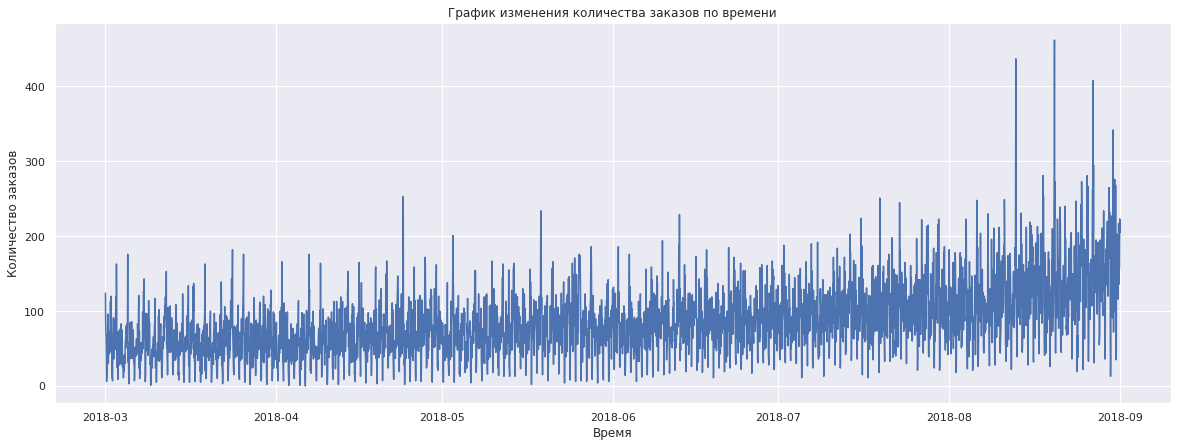

In [ ]:
sns.lineplot(data=df, x=df.index, y='num_orders')\
.set(title='График изменения количества заказов по времени',
    xlabel='Время',
    ylabel='Количество заказов');

Имеющихся данных слишком много, чтобы обоснованно судить о них по одному графику, но похоже, что количество заказов медленно увеличивается каждый месяц и сильно меняется в течение дня.

### Промежуточный вывод

Нам доступен файл с более чем 26 тысячами записей за период с первого марта по 31 августа 2018 года. Пропусков данных нет. Количество заказов находится в столбце `num_orders`.

В соответствии с требованиями заказчика было проведено ресемплирование данных по 1 часу.

Мы готовы к проведению анализа тенденций в данных.

## Анализ

### Скользящее среднее

Чтобы сгладить наш график и получить более наглядное представление данных рассчитаем скользящее среднее.

Для начала посмотрим на скользящее среднее с онкном в один день.

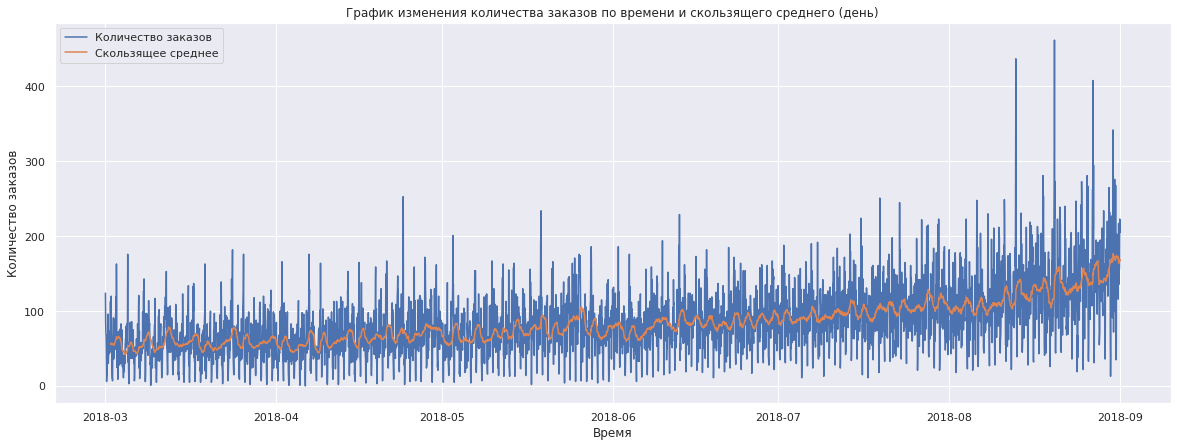

In [ ]:
sns.lineplot(data=df, x=df.index, y='num_orders')\
.set(title='График изменения количества заказов по времени и скользящего среднего (день)',
    xlabel='Время',
    ylabel='Количество заказов')
sns.lineplot(data=df.rolling(24).mean(), x=df.index, y='num_orders');
plt.legend(labels=['Количество заказов', 'Скользящее среднее']);

А теперь посмотрим на скользящее среднее с окном, равным неделе.

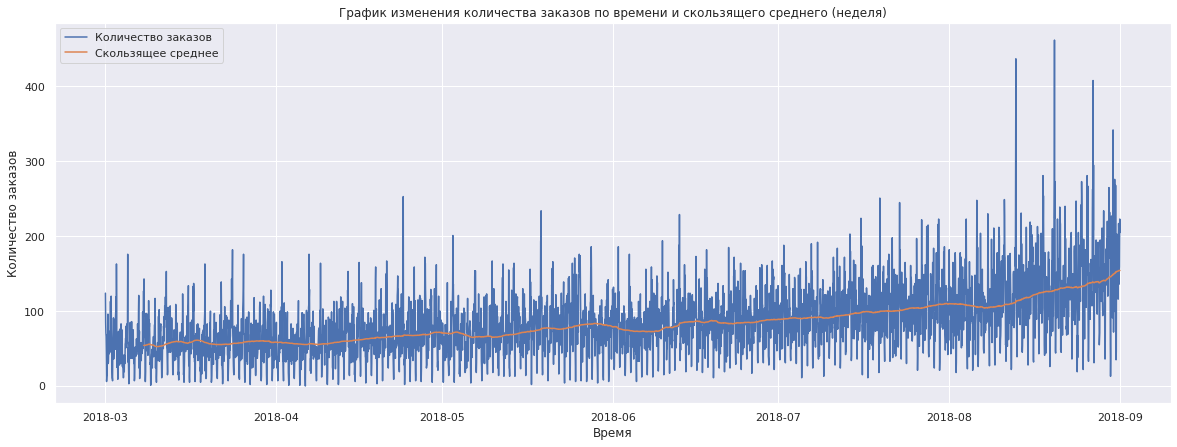

In [ ]:
sns.lineplot(data=df, x=df.index, y='num_orders')\
.set(title='График изменения количества заказов по времени и скользящего среднего (неделя)',
    xlabel='Время',
    ylabel='Количество заказов')
sns.lineplot(data=df.rolling(24*7).mean(), x=df.index, y='num_orders');
plt.legend(labels=['Количество заказов', 'Скользящее среднее']);

График скользящего среднего с окном, равным неделе, более глядкий и наглядный, чем с окном, равным дню. Налицо плавный рост количества заказов.

### Разложение данных на тренд, сезонность и шум

Разделим имеющиеся данные, выделив в них тренд, сезонность и остаток.

In [ ]:
decomposed = seasonal_decompose(df)

Построим наш график с добавлением линии тренда.

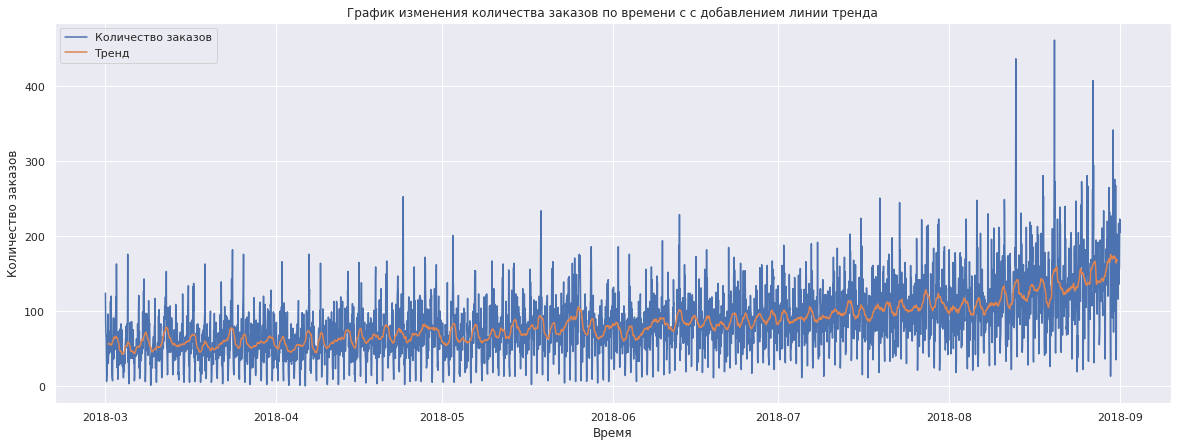

In [ ]:
sns.lineplot(data=df, x=df.index, y='num_orders')\
.set(title='График изменения количества заказов по времени c с добавлением линии тренда',
    xlabel='Время',
    ylabel='Количество заказов')
sns.lineplot(data=decomposed.trend)
plt.legend(labels=['Количество заказов', 'Тренд']);

Похоже, что предположение, которое мы высказали в предыдущем разделе, подтвердилось: в данных наблюдается восходящий тренд.

Отдельно построим графики сезонности для месяца, недели и дня.

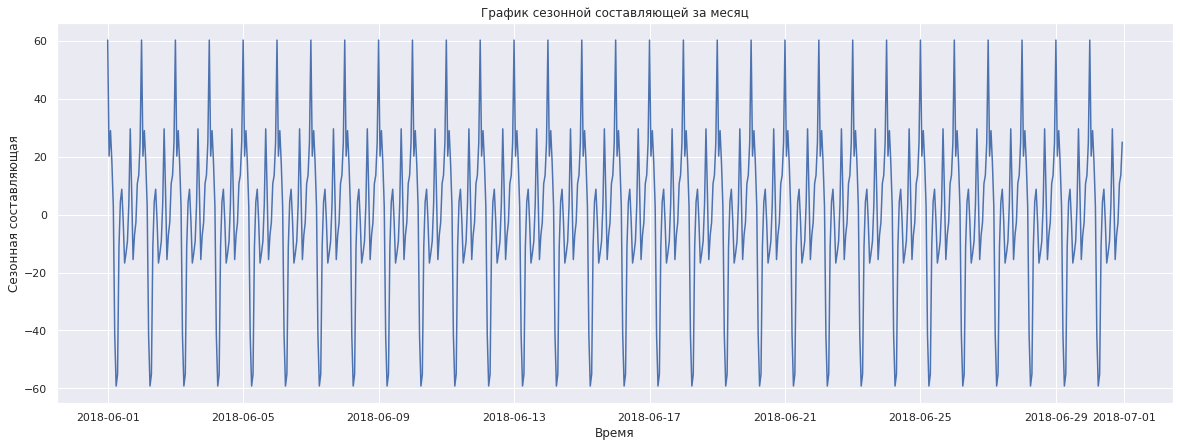

In [ ]:
sns.lineplot(data=decomposed.seasonal['2018-06-01':'2018-06-30'])\
.set(title='График сезонной составляющей за месяц',
     xlabel='Время',
     ylabel='Сезонная составляющая');

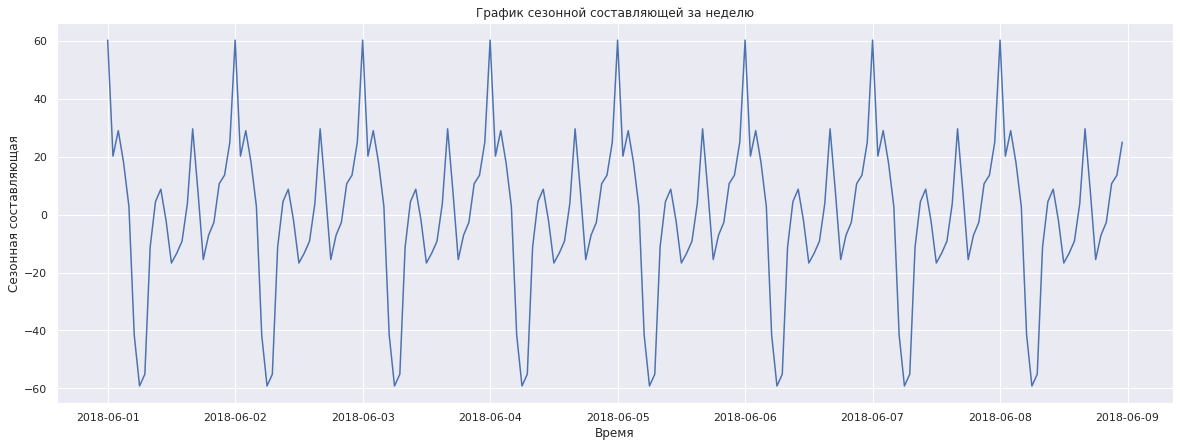

In [ ]:
sns.lineplot(data=decomposed.seasonal['2018-06-01':'2018-06-08'])\
.set(title='График сезонной составляющей за неделю',
     xlabel='Время',
     ylabel='Сезонная составляющая');

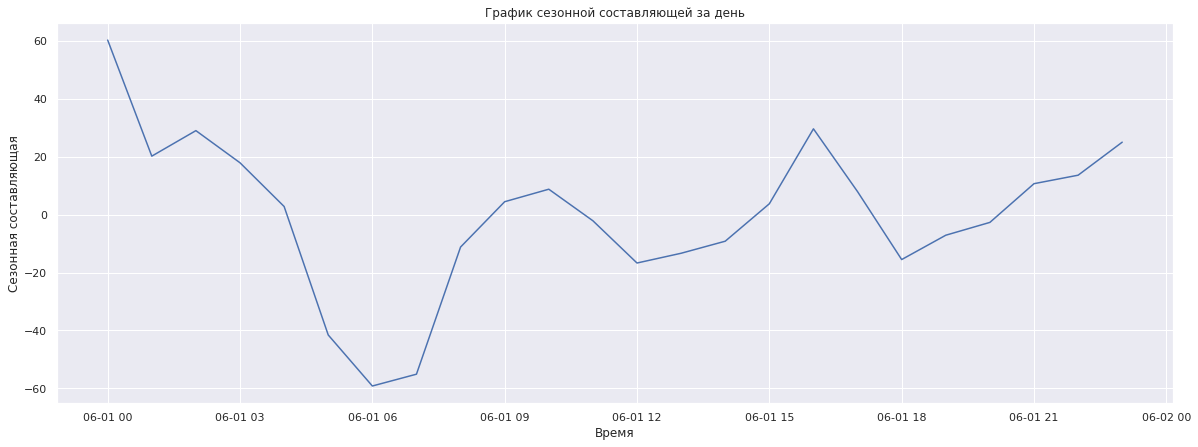

In [ ]:
sns.lineplot(data=decomposed.seasonal['2018-06-01':'2018-06-01'])\
.set(title='График сезонной составляющей за день',
     xlabel='Время',
     ylabel='Сезонная составляющая');

Видно, что алгоритм обнаружил сезонную составляюшую по дням. Пиковая нагрузка приходится на полночь, снижается до шести утра, а затем понемногу возрастает. Возможно это связано с временными циклами городских жителей: около полуночи многие едут домой из баров, а с шести утра спешат на работу.

### Проверка ряда на стационарность

Проверим, можно ли считать наш процесс стационарным. Рассчитаем скользящее среднее, скользящее стандартное отклонение и отобразим их на графике.

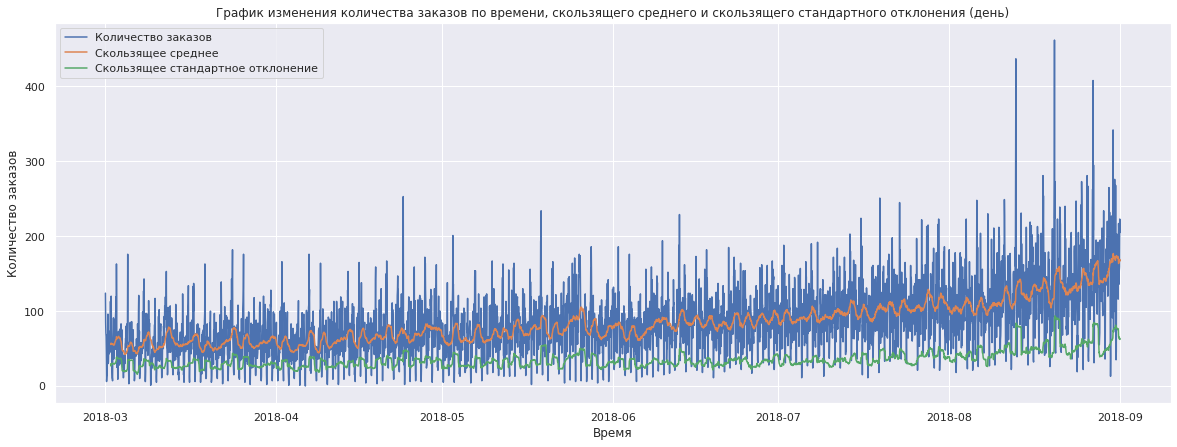

In [ ]:
sns.lineplot(data=df, x=df.index, y='num_orders')\
.set(title='График изменения количества заказов по времени, скользящего среднего и скользящего стандартного отклонения (день)',
    xlabel='Время',
    ylabel='Количество заказов')
sns.lineplot(data=df.rolling(24).mean(), x=df.index, y='num_orders');
sns.lineplot(data=df.rolling(24).std(), x=df.index, y='num_orders');
plt.legend(labels=['Количество заказов', 'Скользящее среднее', 
                   'Скользящее стандартное отклонение']);

Из построенного графика видно, что скользящее среднее и скользящее стандартное отклонение меняются со временем. Чтобы сделать временной ряд более стационарным нужно будет рассчитать разности временного ряда.

### Промежуточный вывод

Чтобы сгладить данные мы рассчитали и построили графики скользящего среднего с окном в один день и в одну неделю. График скользящего среднего с окном в одну неделю наглядно показал плавный рост количества заказов со временем.

Затем мы разделили данные на тренд, сезонность и шум. Рассчитанный тренд также продемонстрировал постепенный рост количества заказов. Алгоритм выделил сезонную составляюшую данных по дням. Пиковая нагрузка приходится на полночь, снижается до шести утра, а затем понемногу возрастает. Возможно это связано с временными циклами городских жителей: около полуночи многие едут домой из баров, а с шести утра спешат на работу.

Для проверки ряда на стационарность мы расчитали скользящее среднее и скользящее стандартное отклонение. Из построенного графика видно, что скользящее среднее и скользящее стандартное отклонение меняются со временем, что говорит о нестационарности данных. Чтобы сделать временной ряд более стационарным нужно будет рассчитать разности временного ряда.

## Обучение

### Подготовка данных

Добавим в массив данных признаки, которые будут полезны при обучении моделей.

Создадим отдельные признаки для месяца, дня, дня недели и часа. Месяц может влиять на количество заказов, возможно зимой такси заказывают чаще. День месяца также может быть полезным признаком: например, у некоторых офисных работников в конце месяца очень напряжённое время: надо сдавать отчёты. Возможно у таксистов наблюдается схожий эффект и по какой-то причине в конце месяца количество заказов увеличивается.

In [ ]:
df['dayofweek'] = df.index.dayofweek
df['hour'] = df.index.hour
df['month'] = df.index.month
df['day'] = df.index.day

Нам также понадобятся "отстающие значения" *(lag features)* и скользящее среднее. Количество "отстающих" признаков и размер окна для скользящего среднего придётся подбирать, поэтому позднее мы реализуем их формирование в цикле оптимизатора _optuna_.

Разделим данные на обучающую и тестовую выборки.

In [ ]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

### Линейная регрессия

Обучим модель на основе линейной регрессии.

In [ ]:
def objective(trial):
    train_trial = train.copy()

    n_lag = trial.suggest_int('n_lag', 5, 35)
    w_size = trial.suggest_int('w_size', 5, 35)

    for lag in range(1, n_lag + 1):
        train_trial[f'lag_{lag}'] = train_trial['num_orders'].shift(lag)

    train_trial['rolling_mean'] = train_trial['num_orders'].shift()\
    .rolling(w_size).mean()

    train_trial = train_trial.dropna()

    X_train = train_trial.drop('num_orders', axis=1)
    y_train = train_trial['num_orders']

    model = LinearRegression()

    tscv = TimeSeriesSplit(n_splits=8)
    score = cross_val_score(model, X_train, y_train, 
                            scoring='neg_root_mean_squared_error',
                            n_jobs=-1, cv=tscv)

    return score.mean()

In [ ]:
study_lr = optuna.create_study(direction='maximize', sampler=RandomSampler(seed=42))
study_lr.optimize(objective, n_trials=100)

[I 2022-09-06 18:07:51,824] A new study created in memory with name: no-name-8cc42a43-bf66-4e6d-aeb2-1ab19f378c8c
[I 2022-09-06 18:07:53,020] Trial 0 finished with value: -30.708535946081152 and parameters: {'n_lag': 16, 'w_size': 34}. Best is trial 0 with value: -30.708535946081152.
[I 2022-09-06 18:07:53,110] Trial 1 finished with value: -132395267961.92052 and parameters: {'n_lag': 27, 'w_size': 23}. Best is trial 0 with value: -30.708535946081152.
[I 2022-09-06 18:07:53,173] Trial 2 finished with value: -30.954654713171486 and parameters: {'n_lag': 9, 'w_size': 9}. Best is trial 0 with value: -30.708535946081152.
[I 2022-09-06 18:07:53,234] Trial 3 finished with value: -31.146883124106413 and parameters: {'n_lag': 6, 'w_size': 31}. Best is trial 0 with value: -30.708535946081152.
[I 2022-09-06 18:07:53,315] Trial 4 finished with value: -28.32268001581246 and parameters: {'n_lag': 23, 'w_size': 26}. Best is trial 4 with value: -28.32268001581246.
[I 2022-09-06 18:07:53,376] Trial 5 

In [ ]:
round(study_lr.best_value, 2)

-26.02

На кросс-валидации линейная регрессия обеспечила значение метрики RMSE 26.02.

### LightGBM

Обучим модель на основе градиентного бустинга.

In [ ]:
def objective_lgbm(trial):
    train_trial = train.copy()

    n_lag = trial.suggest_int('n_lag', 5, 35)
    w_size = trial.suggest_int('w_size', 5, 35)

    for lag in range(1, n_lag + 1):
        train_trial[f'lag_{lag}'] = train_trial['num_orders'].shift(lag)

    train_trial['rolling_mean'] = train_trial['num_orders'].shift()\
    .rolling(w_size).mean()

    train_trial = train_trial.dropna()

    X_train = train_trial.drop('num_orders', axis=1)
    y_train = train_trial['num_orders']

    model = LGBMRegressor(random_state=42)

    params = {
        'metric': 'root_mean_squared_error',
        'learning_rate ': trial.suggest_float('learning_rate', .01, .5),
        'max_depth': trial.suggest_int('max_depth', 3, 10, step=1),
        'n_jobs': -1
    }

    model = LGBMRegressor(objective='regression', **params)

    tscv = TimeSeriesSplit(n_splits=8)
    score = cross_val_score(model, X_train, y_train, 
                            scoring='neg_root_mean_squared_error',
                            n_jobs=-1, cv=tscv)

    return score.mean()

In [ ]:
study_lgbm = optuna.create_study(direction='maximize', sampler=RandomSampler(seed=42))
study_lgbm.optimize(objective_lgbm, n_trials=100)

[I 2022-09-06 18:09:53,478] A new study created in memory with name: no-name-2516a441-5843-4f5d-886d-9f7adb5e4135
[I 2022-09-06 18:09:54,283] Trial 0 finished with value: -24.412038182006704 and parameters: {'n_lag': 16, 'w_size': 34, 'learning_rate': 0.3686770314875885, 'max_depth': 7}. Best is trial 0 with value: -24.412038182006704.
[I 2022-09-06 18:09:54,831] Trial 1 finished with value: -24.3553757149738 and parameters: {'n_lag': 9, 'w_size': 9, 'learning_rate': 0.03846096996241773, 'max_depth': 9}. Best is trial 1 with value: -24.3553757149738.
[I 2022-09-06 18:09:55,898] Trial 2 finished with value: -24.628640573740732 and parameters: {'n_lag': 23, 'w_size': 26, 'learning_rate': 0.020086402204943198, 'max_depth': 10}. Best is trial 1 with value: -24.3553757149738.
[I 2022-09-06 18:09:56,471] Trial 3 finished with value: -24.262561939820294 and parameters: {'n_lag': 30, 'w_size': 11, 'learning_rate': 0.0990942339314793, 'max_depth': 4}. Best is trial 3 with value: -24.26256193982

In [ ]:
round(study_lgbm.best_value, 2)

-24.03

На кросс-валидации LightGBM обеспечила значение метрики RMSE 24.03.

### Голосующий ансамбль

Попробуем применить голосующий ансамбль. Добавим в него линейную регрессиию, LightGBM и немного метода ближайших соседей.

In [ ]:
def objective_vote(trial):
    train_trial = train.copy()

    n_lag = trial.suggest_int('n_lag', 5, 35)
    w_size = trial.suggest_int('w_size', 5, 35)

    for lag in range(1, n_lag + 1):
        train_trial[f'lag_{lag}'] = train_trial['num_orders'].shift(lag)

    train_trial['rolling_mean'] = train_trial['num_orders'].shift()\
    .rolling(w_size).mean()

    train_trial = train_trial.dropna()

    X_train = train_trial.drop('num_orders', axis=1)
    y_train = train_trial['num_orders']

    params = {
        'metric': 'root_mean_squared_error',
        'learning_rate ': trial.suggest_float('learning_rate', .01, .5),
        'max_depth': trial.suggest_int('max_depth', 3, 10, step=1),
        'n_jobs': -1
    }

    lgbm = LGBMRegressor(objective='regression', random_state=42, **params)

    lr = LinearRegression()

    pipe = Pipeline([('scaler', MinMaxScaler()), 
                     ('knn', KNeighborsRegressor())])

    model = VotingRegressor([('lgbm', lgbm), ('lr', lr), ('pipe', pipe)])

    tscv = TimeSeriesSplit(n_splits=8)
    score = cross_val_score(model, X_train, y_train, 
                            scoring='neg_root_mean_squared_error',
                            n_jobs=-1, cv=tscv)

    return score.mean()

In [ ]:
study_vote = optuna.create_study(direction='maximize', 
                                 sampler=RandomSampler(seed=42))
study_vote.optimize(objective_vote, n_trials=100)

[I 2022-09-06 18:16:41,607] A new study created in memory with name: no-name-58116dd4-cdb8-407c-b784-d421ddf5f93f
[I 2022-09-06 18:16:42,439] Trial 0 finished with value: -25.45558171623661 and parameters: {'n_lag': 16, 'w_size': 34, 'learning_rate': 0.3686770314875885, 'max_depth': 7}. Best is trial 0 with value: -25.45558171623661.
[I 2022-09-06 18:16:43,082] Trial 1 finished with value: -25.840749441708148 and parameters: {'n_lag': 9, 'w_size': 9, 'learning_rate': 0.03846096996241773, 'max_depth': 9}. Best is trial 0 with value: -25.45558171623661.
[I 2022-09-06 18:16:44,815] Trial 2 finished with value: -24.471317935271195 and parameters: {'n_lag': 23, 'w_size': 26, 'learning_rate': 0.020086402204943198, 'max_depth': 10}. Best is trial 2 with value: -24.471317935271195.
[I 2022-09-06 18:16:45,549] Trial 3 finished with value: -14593777306.287945 and parameters: {'n_lag': 30, 'w_size': 11, 'learning_rate': 0.0990942339314793, 'max_depth': 4}. Best is trial 2 with value: -24.47131793

In [ ]:
round(study_vote.best_value, 2)

-23.53

На кросс-валидации ансамбль обеспечил значение метрики RMSE 23.53.

### Проверка на адекватность

Для проверки моделей на адекватность предскажем тестовые данные предыдущим значением. Если значение метрики RMSE при этом будет ниже, чем у наших моделей, то проверку на адекватность можно считать пройденой.

In [ ]:
y_train = train['num_orders']
y_test = test['num_orders']

In [ ]:
y_pred_prev = y_test.shift(1, fill_value=y_train[-1])

In [ ]:
round(mean_squared_error(y_test, y_pred_prev, squared=False), 2)

58.86

Значение метрики значительно выше, чем у наших моделей. Проверка на адекватность пройдена.

### Промежуточный вывод

Мы добавили в массив данных несколько дополнительных признаков. При этом часть признаков (месяц, день, день недели, час) мы добавили сразу, а количество оставшихся признаков мы подбирали оптимизатором *optuna*.

Для прогнозирования временного ряда мы обучили и оптимизировали на кросс-валидации три модели:
* линейную регрессию
* LightGBM
* голосующий ансамбль.

Кроме того мы провели проверку на адекватность: обучили "глупую" модель, предсказывающую данные предыдущим значением.

Сведём значения метрики RMSE для всех моделей в единую таблицу.

| Модель         | RMSE     |
|--------------|-----------|
| Линейная регрессия | 26.02      |
| LightGBM      | 24.03  |
| Голосующий ансамбль      | 23.53  |
| «Глупая» модель      | 58.86  |

Исходя из значений метрики мы отобрали для тестирования модель на основе голосующего ансамбля.

## Тестирование

Похоже, что голосующий ансамбль обеспечивает наилучшее значение метрики RMSE на кросс-валидации. Посчитаем значение метрики на тестовой выборке.

In [ ]:
n_lag, w_size, lr, max_depth = study_vote.best_params.values()

Создадим нужные нам признаки и снова выделим тестовую выборку.

In [ ]:
for lag in range(1, n_lag + 1):
    df[f'lag_{lag}'] = df['num_orders'].shift(lag)

df['rolling_mean'] = df['num_orders'].shift()\
.rolling(w_size).mean()

In [ ]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

In [ ]:
train = train.dropna()

In [ ]:
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']

X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

In [ ]:
params = {
        'metric': 'root_mean_squared_error',
        'learning_rate ': lr,
        'max_depth': max_depth,
        'n_jobs': -1
    }

In [ ]:
lgbm = LGBMRegressor(objective='regression', random_state=42, **params)
lr = LinearRegression()
pipe = Pipeline([('scaler', MinMaxScaler()), ('knn', KNeighborsRegressor())])
model = VotingRegressor([('lgbm', lgbm), ('lr', lr), ('pipe', pipe)])

In [ ]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

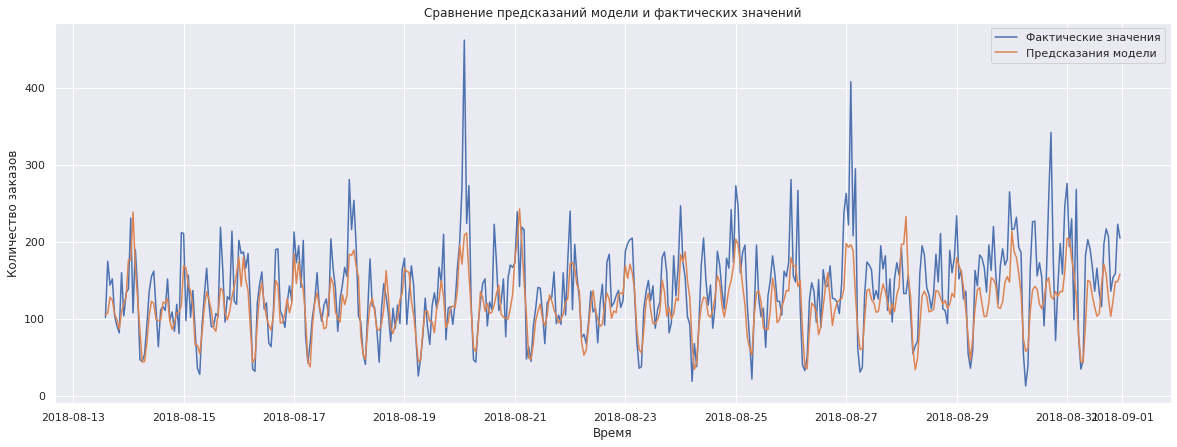

In [ ]:
sns.lineplot(y=y_test, x = y_test.index)
sns.lineplot(y=y_pred, x = y_test.index)\
.set(title='Сравнение предсказаний модели и фактических значений',
     xlabel='Время',
     ylabel='Количество заказов');
plt.legend(['Фактические значения', 'Предсказания модели']);

In [ ]:
round(mean_squared_error(y_test, y_pred, squared=False), 2)

44.27

### Промежуточные выводы

Для проведения тестирования мы отобрали модель на основе голосующего ансамбля. Затем мы рассчитали значение метрики на тестовых данных: RMSE=44.27. Метрика оказалась ниже, чем пороговое значение, установленное заказчиком (48). Именно эту модель мы рекомендуем заказчику.

## Вывод по проекту

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Задача:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

Нам был передан файл с более чем 26 тысячами записей за период с первого марта по 31 августа 2018 года. Пропусков данных нет. Количество заказов находится в столбце `num_orders`.

В соответствии с требованиями заказчика было проведено ресемплирование данных по 1 часу.

Чтобы сгладить данные мы рассчитали и построили графики скользящего среднего с окном в один день и в одну неделю. График скользящего среднего с окном в одну неделю наглядно показал плавный рост количества заказов со временем.

Затем мы разделили данные на тренд, сезонность и шум. Рассчитанный тренд также продемонстрировал постепенный рост количества заказов. Алгоритм выделил сезонную составляюшую данных по дням. Пиковая нагрузка приходится на полночь, снижается до шести утра, а затем понемногу возрастает. Возможно это связано с временными циклами городских жителей: около полуночи многие едут домой из баров, а с шести утра спешат на работу.

Для проверки ряда на стационарность мы расчитали скользящее среднее и скользящее стандартное отклонение. Из построенного графика видно, что скользящее среднее и скользящее стандартное отклонение меняются со временем, что говорит о нестационарности данных. Чтобы сделать временной ряд более стационарным нужно будет рассчитать разности временного ряда.

Мы добавили в массив данных несколько дополнительных признаков. При этом часть признаков (месяц, день, день недели, час) мы добавили сразу, а количество оставшихся признаков мы подбирали оптимизатором *optuna*.

Для прогнозирования временного ряда мы обучили и оптимизировали на кросс-валидации три модели:
* линейную регрессию
* LightGBM
* голосующий ансамбль.

Кроме того мы провели проверку на адекватность: обучили "глупую" модель, предсказывающую данные предыдущим значением.

Сведём значения метрики RMSE для всех моделей в единую таблицу.

| Модель         | RMSE     |
|--------------|-----------|
| Линейная регрессия | 26.02      |
| LightGBM      | 24.03  |
| Голосующий ансамбль      | 23.53  |
| «Глупая» модель      | 58.86  |

Для проведения тестирования мы отобрали модель на основе голосующего ансамбля. Затем мы рассчитали значение метрики на тестовых данных: RMSE=44.27. Метрика оказалась ниже, чем пороговое значение, установленное заказчиком (48). Именно эту модель мы рекомендуем заказчику.